# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

##### Formulas:

$\frac{\partial L(w, w_0)}{\partial  w_0} = \frac{1}{N} \sum^N_{i=1} \frac{exp(-y_i(w^Tx_i-w_0))}{1 + exp(-y_i(w^Tx_i-w_0))} y_i$

$\frac{\partial L(w, w_0)}{\partial  w} = \frac{1}{N} \sum^N_{i=1} \frac{exp(-y_i(w^Tx_i-w_0))}{1 + exp(-y_i(w^Tx_i-w_0))} (-y_ix_i) + \gamma \cdot sg(w) + 2\beta w$

#### 2. [0.5 points] Implement the Elastic Net loss (as a function)

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    result = (np.log(1 + np.exp(-y * (X @ w + w0)))).mean()
    result += gamma * np.sum(np.abs(w))
    result += beta * np.sum(np.power(w, 2))
    
    return result

#### 3. [0.5 points] Implement the gradient (as a function)

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    frac = np.exp(- y * (X @ w + w0)) / (1 + np.exp(- y * (X @ w + w0)))
    grad_w0 = (frac * (-y)).mean()
    grad_w = (frac * ((- X.T) * y)).mean(axis=1)
    grad_w += gamma * np.sign(w)
    grad_w += beta * 2 * w
    return grad_w, grad_w0

#### Check yourself

In [4]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import unique_labels

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-4, max_iter=1000, random_state=42):  
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.lr = lr
        self.random_state = random_state
        self.w = None
        self.w0 = None 
        self.loss_history = None 
        
    def _is_tolerance(self, w, new_w, w0, new_w0):
        if np.linalg.norm(w - new_w) <= self.tolerance and np.abs(w0 - new_w0) <= self.tolerance:
            return False
        else:
            return True
        
    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        
        self.classes_ = unique_labels(y)
        
        self.loss_history = []
            
        np.random.seed(self.random_state)
        self.w = np.random.normal(0,1,size=X[0].size)
        self.w0 = np.random.normal(0,1)
        
        for i in tqdm(range(self.max_iter)):
            grad_w, grad_w0 = self.calc_gradient(X, y)
            new_w = self.w - self.lr * grad_w
            new_w0 = self.w0 - self.lr * grad_w0
            
            if not self._is_tolerance(self.w, new_w, self.w0, new_w0):
                break
                
            self.w = new_w.copy()
            self.w0 = new_w0.copy()
            self.loss_history.append(self.calc_loss(X,y))

        return self
    
    def calc_gradient(self, X, y):
        frac = np.exp(- y * (X @ self.w + self.w0)) / (1 + np.exp(- y * (X @ self.w + self.w0)))
        grad_w0 = (frac * (-y)).mean()
        grad_w = (frac * ((- X.T) * y)).mean(axis=1)
        grad_w += self.gamma * np.sign(self.w)
        grad_w += self.beta * 2 * self.w
        return grad_w, grad_w0

    def predict(self, X):
        preds = self.predict_proba(X).T[0]
        preds_classes = np.ones(preds.shape[0])
        preds_classes[preds>0.5] = -1
        return preds_classes
    
    def calc_loss(self, X, y):
        result = (np.log(1 + np.exp(-y * (X @ self.w + self.w0)))).mean()
        result += self.gamma * np.sum(np.abs(self.w))
        result += self.beta * np.sum(np.power(self.w, 2))
        return result
        
    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(np.dot(X, self.w) + self.w0)),\
                         1 / (1 + np.exp(-np.dot(X, self.w) - self.w0))]).T

In [7]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [8]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

100%|██████████| 1000/1000 [00:00<00:00, 9344.22it/s]


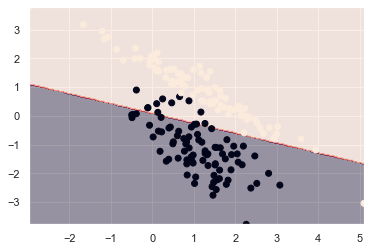

In [9]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

In [10]:
from sklearn.metrics import accuracy_score
preds = model.predict(X)
accuracy_score(y, preds)

0.9333333333333333

#### 5. [0.5 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

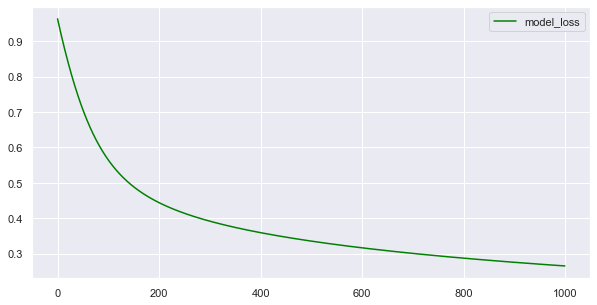

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(model.loss_history, label='model_loss', color='green')
plt.legend()
plt.show()

## PART 2: Support Vector Machines

#### 6. [1 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [12]:
# Add nore data for testing
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=360, n_features=2, n_redundant=0, n_informative=2,
                               random_state=45, n_clusters_per_class=1)

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

100%|██████████| 2000/2000 [00:25<00:00, 79.01it/s]


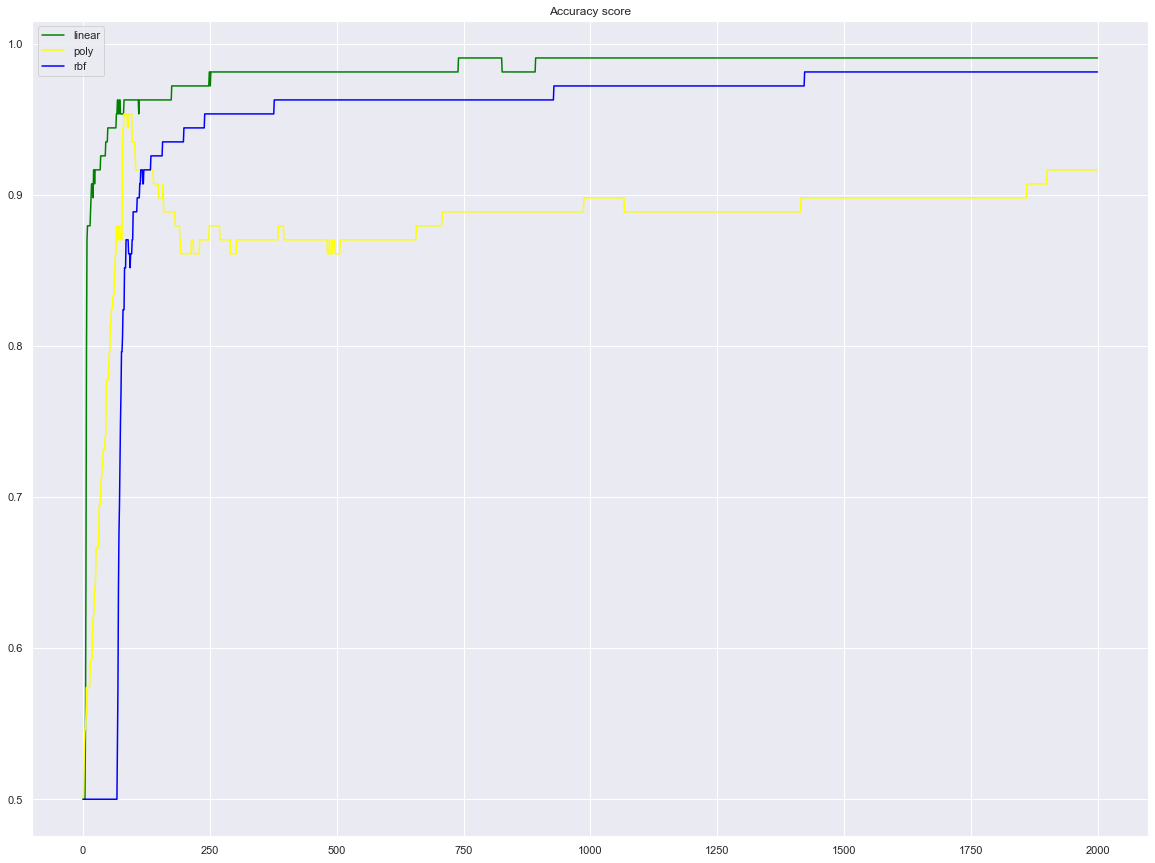

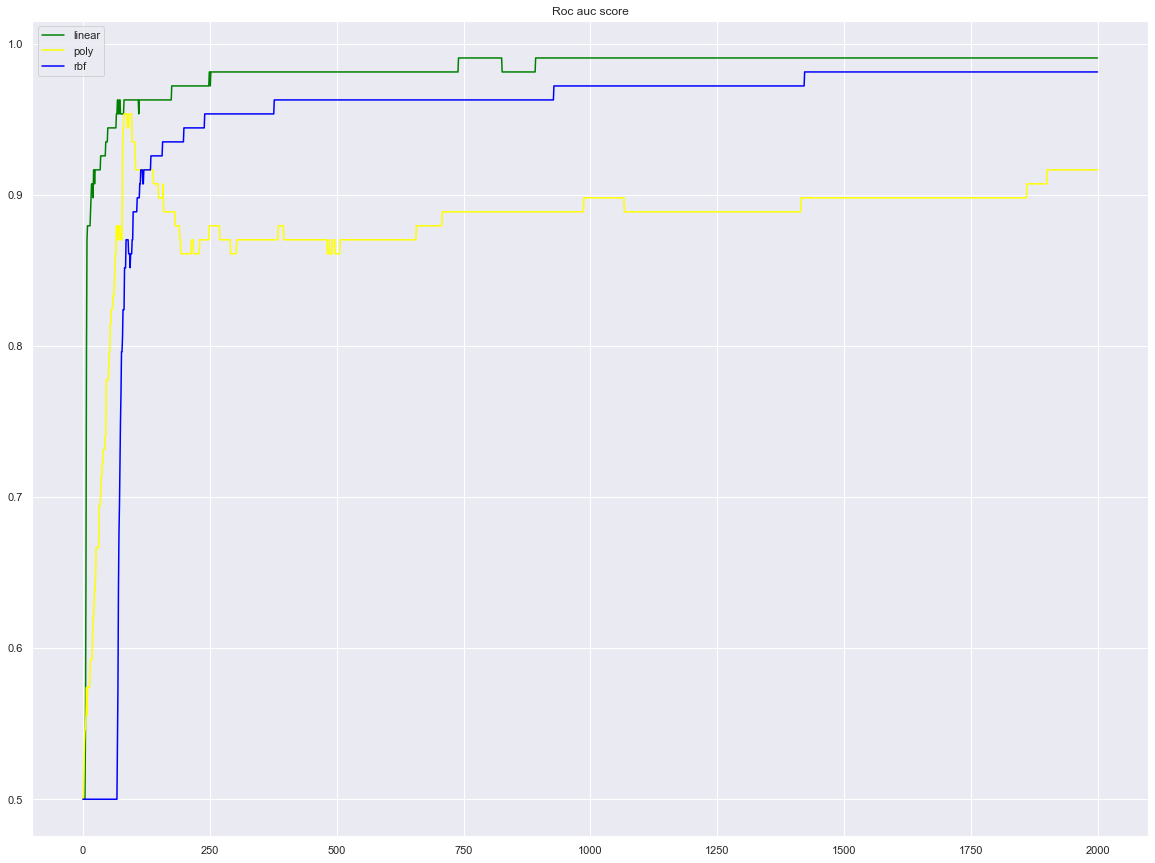

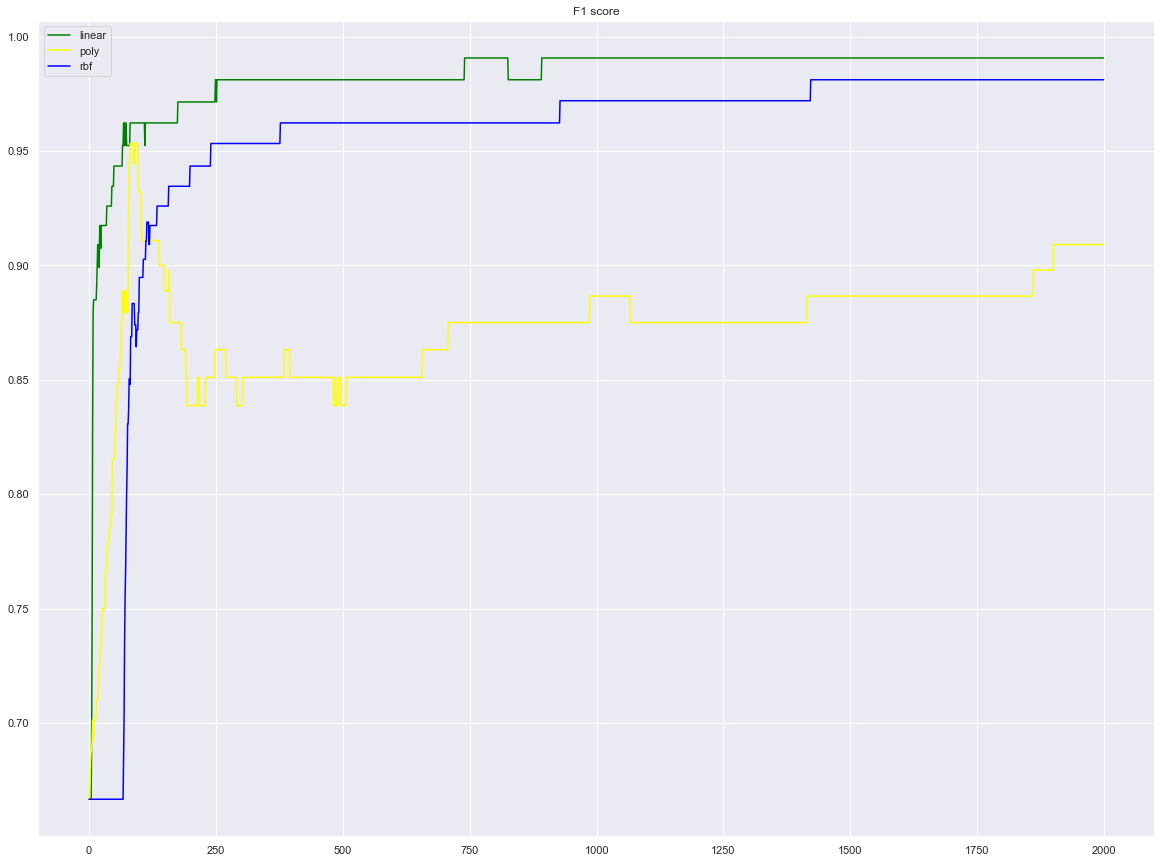

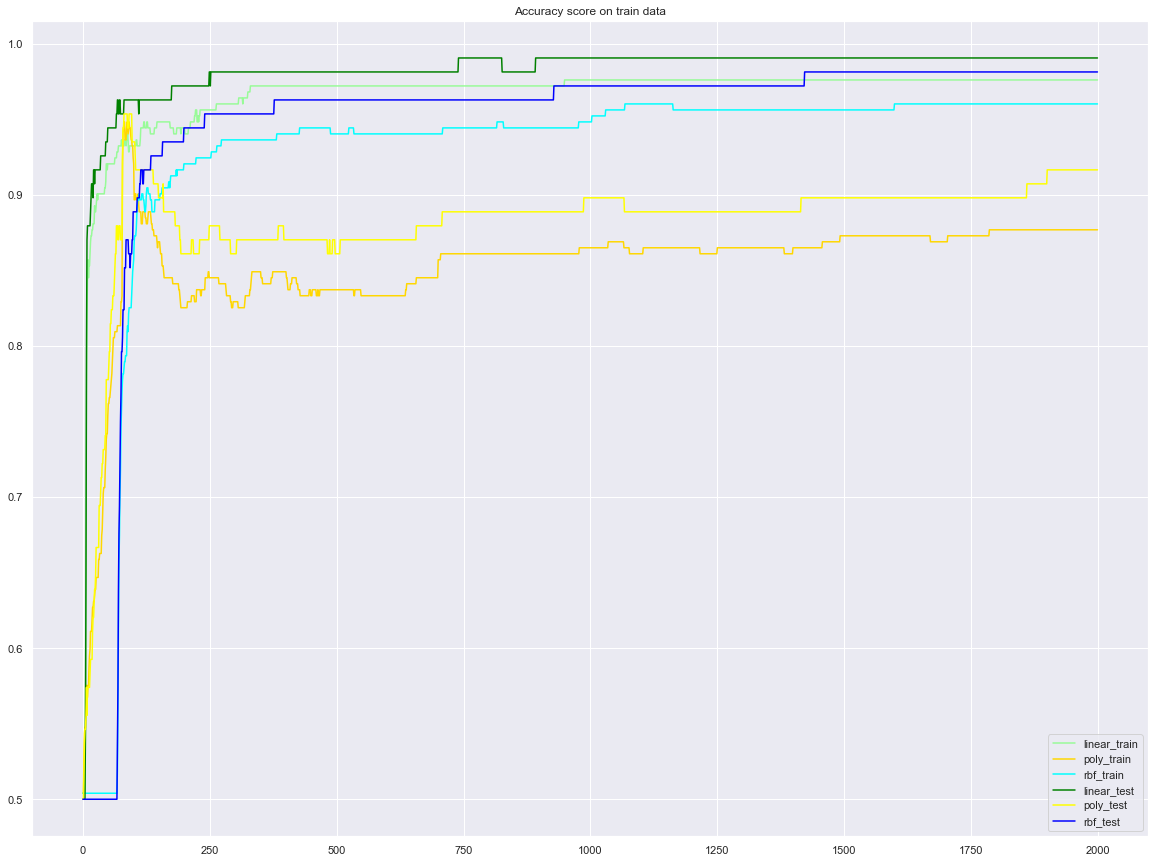

In [14]:
linear_regCoef = {'accuracy_score' : [], 'roc_auc_score': [], 'f1_score': [], 'accuracy_score_train' : []}
poly_regCoef = {'accuracy_score' : [], 'roc_auc_score': [], 'f1_score': [], 'accuracy_score_train' : []}
rbf_regCoef = {'accuracy_score' : [], 'roc_auc_score': [], 'f1_score': [], 'accuracy_score_train' : []}

for i in tqdm(np.linspace(0.0001,0.25,2000)):
    model = SVC(C=i, kernel='linear')
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    prediction_train = model.predict(X_train)
    linear_regCoef['accuracy_score_train'].append(accuracy_score(y_train, prediction_train))
    linear_regCoef['accuracy_score'].append(accuracy_score(y_test, prediction_test))
    linear_regCoef['roc_auc_score'].append(roc_auc_score(y_test, prediction_test))
    linear_regCoef['f1_score'].append(f1_score(y_test, prediction_test))
    
    model = SVC(C=i, kernel='poly')
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    prediction_train = model.predict(X_train)
    poly_regCoef['accuracy_score_train'].append(accuracy_score(y_train, prediction_train))
    poly_regCoef['accuracy_score'].append(accuracy_score(y_test, prediction_test))
    poly_regCoef['roc_auc_score'].append(roc_auc_score(y_test, prediction_test))
    poly_regCoef['f1_score'].append(f1_score(y_test, prediction_test))
    
    model = SVC(C=i, kernel='rbf')
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    prediction_train = model.predict(X_train)
    rbf_regCoef['accuracy_score_train'].append(accuracy_score(y_train, prediction_train))
    rbf_regCoef['accuracy_score'].append(accuracy_score(y_test, prediction_test))
    rbf_regCoef['roc_auc_score'].append(roc_auc_score(y_test, prediction_test))
    rbf_regCoef['f1_score'].append(f1_score(y_test, prediction_test))

plt.figure(figsize=(20, 15))
plt.plot(linear_regCoef['accuracy_score'], label='linear', color='green')
plt.plot(poly_regCoef['accuracy_score'], label='poly', color='yellow')
plt.plot(rbf_regCoef['accuracy_score'], label='rbf', color='blue')
plt.title("Accuracy score")
plt.legend()
plt.show()

plt.figure(figsize=(20, 15))
plt.plot(linear_regCoef['roc_auc_score'], label='linear', color='green')
plt.plot(poly_regCoef['roc_auc_score'], label='poly', color='yellow')
plt.plot(rbf_regCoef['roc_auc_score'], label='rbf', color='blue')
plt.title("Roc auc score")
plt.legend()
plt.show()

plt.figure(figsize=(20, 15))
plt.plot(linear_regCoef['f1_score'], label='linear', color='green')
plt.plot(poly_regCoef['f1_score'], label='poly', color='yellow')
plt.plot(rbf_regCoef['f1_score'], label='rbf', color='blue')
plt.title("F1 score")
plt.legend()
plt.show()

plt.figure(figsize=(20, 15))
plt.plot(linear_regCoef['accuracy_score_train'], label='linear_train', color='palegreen')
plt.plot(poly_regCoef['accuracy_score_train'], label='poly_train', color='gold')
plt.plot(rbf_regCoef['accuracy_score_train'], label='rbf_train', color='cyan')
plt.plot(linear_regCoef['accuracy_score'], label='linear_test', color='green')
plt.plot(poly_regCoef['accuracy_score'], label='poly_test', color='yellow')
plt.plot(rbf_regCoef['accuracy_score'], label='rbf_test', color='blue')
plt.title("Accuracy score on train data")
plt.legend()
plt.show()

In [15]:
print("Poly model:")

model = SVC(kernel='poly', gamma='auto')
model.fit(X_train, y_train)
prediction_test = model.predict(X_test)
print("\tAccuracy score auto: ", accuracy_score(y_test, prediction_test))
print("\tRoc auc score auto: ", roc_auc_score(y_test, prediction_test))
print("\tF1 score auto: ", f1_score(y_test, prediction_test))

model = SVC(kernel='poly', gamma='scale')
model.fit(X_train, y_train)
prediction_test = model.predict(X_test)
print("\tAccuracy score scale: ", accuracy_score(y_test, prediction_test))
print("\tRoc auc score scale: ", roc_auc_score(y_test, prediction_test))
print("\tF1 score scale: ", f1_score(y_test, prediction_test))


Poly model:
	Accuracy score auto:  0.9537037037037037
	Roc auc score auto:  0.9537037037037037
	F1 score auto:  0.9514563106796117
	Accuracy score scale:  0.9351851851851852
	Roc auc score scale:  0.9351851851851851
	F1 score scale:  0.9306930693069307


In [16]:
print("Rbf model:")

model = SVC(kernel='rbf', gamma='auto')
model.fit(X_train, y_train)
prediction_test = model.predict(X_test)
print("\tAccuracy score auto: ", accuracy_score(y_test, prediction_test))
print("\tRoc auc score auto: ", roc_auc_score(y_test, prediction_test))
print("\tF1 score auto: ", f1_score(y_test, prediction_test))

model = SVC(kernel='rbf', gamma='scale')
model.fit(X_train, y_train)
prediction_test = model.predict(X_test)
print("\tAccuracy score scale: ", accuracy_score(y_test, prediction_test))
print("\tRoc auc score scale: ", roc_auc_score(y_test, prediction_test))
print("\tF1 score scale: ", f1_score(y_test, prediction_test))

Rbf model:
	Accuracy score auto:  0.9907407407407407
	Roc auc score auto:  0.9907407407407407
	F1 score auto:  0.9906542056074767
	Accuracy score scale:  0.9907407407407407
	Roc auc score scale:  0.9907407407407407
	F1 score scale:  0.9906542056074767


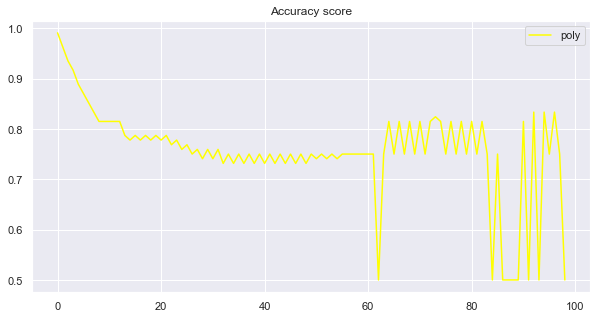

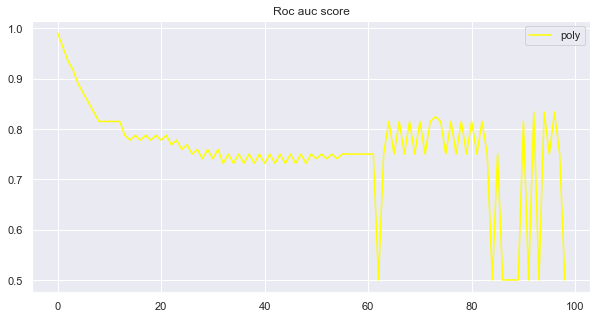

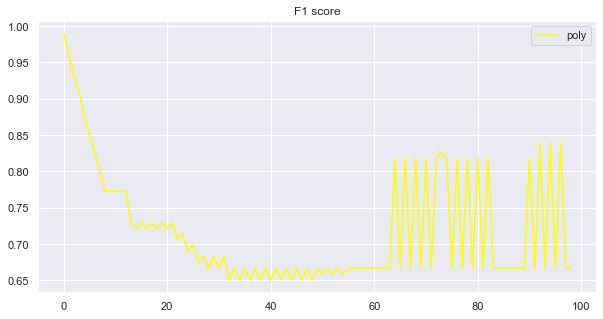

In [17]:
poly_degree = {'accuracy_score' : [], 'roc_auc_score': [], 'f1_score': []}

for i in range(1, 100):
    model = SVC(kernel='poly', degree=i)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    poly_degree['accuracy_score'].append(accuracy_score(y_test, prediction_test))
    poly_degree['roc_auc_score'].append(roc_auc_score(y_test, prediction_test))
    poly_degree['f1_score'].append(f1_score(y_test, prediction_test))
   

plt.figure(figsize=(10, 5))
plt.plot(poly_degree['accuracy_score'], label='poly', color='yellow')
plt.title("Accuracy score")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(poly_degree['roc_auc_score'], label='poly', color='yellow')
plt.title("Roc auc score")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(poly_degree['f1_score'], label='poly', color='yellow')
plt.title("F1 score")
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:02<00:00, 478.92it/s]


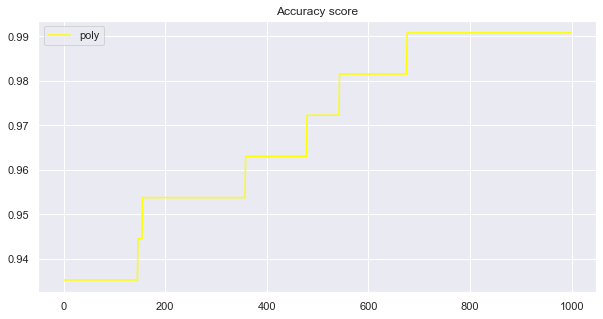

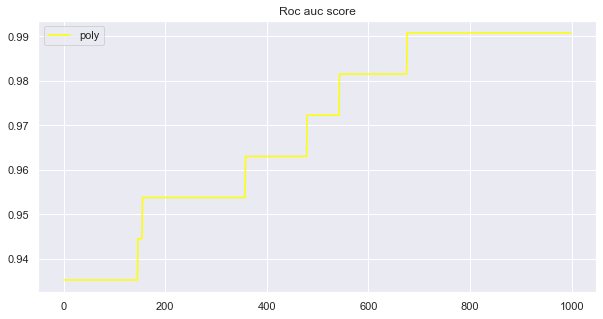

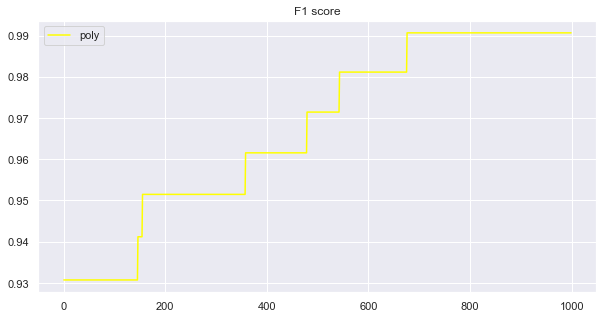

In [18]:
poly_coef0 = {'accuracy_score' : [], 'roc_auc_score': [], 'f1_score': []}

for i in tqdm(np.linspace(0.0001,0.5,1000)):
    model = SVC(kernel='poly', coef0=i)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    poly_coef0['accuracy_score'].append(accuracy_score(y_test, prediction_test))
    poly_coef0['roc_auc_score'].append(roc_auc_score(y_test, prediction_test))
    poly_coef0['f1_score'].append(f1_score(y_test, prediction_test))
    

plt.figure(figsize=(10, 5))
plt.plot(poly_coef0['accuracy_score'], label='poly', color='yellow')
plt.title("Accuracy score")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(poly_coef0['roc_auc_score'], label='poly', color='yellow')
plt.title("Roc auc score")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(poly_coef0['f1_score'], label='poly', color='yellow')
plt.title("F1 score")
plt.legend()
plt.show()

## Summary

From the obtained graphs we can conclude that all three kernels studied are quite sensitive to the regularization parameter and it should be chosen carefully. The regularization has the strongest effect on the poly model. Its quality is significantly spoiled if the regularization parameter is too small or too large. It is also worth noting that the choice of coef0 and degree  hyperparameters has a significant effect, small values of degree and large values of coef0 worked better on the generated sample. Less strong but noticeable effect of gamma parameter on the poly kernel, metrics show that the value auto works better than scale. The effect on the rbf kernel is not noticeable. 

To analyze overfitting we calculated accuracy for models with different regularization parameter and calculated metrics on test and raw data. The percentage of hits for the rbf kernel changes most dramatically. Also for this kernel the effect of regularization on overfitting is noticeable, but insignificant.  Much more strongly regularization affects overfitting in the linear model. The poly kernel behaves quite strangely and shows better results on test data than on training data.

## PART 3: Natural Language Processing

#### 7. [2 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: 
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "30k : 15k : 7k : 20k: 40k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset 
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and lemmatize the words
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [19]:
import nltk.data

def get_author_sentences(author):
    tokenizer = nltk.data.load('tokenizers/punkt/PY3/russian.pickle')
    sentences = []
    for file_name in tqdm(glob.glob(author + '/*.txt')):
        with open(file_name, 'r') as file:
            text = file.read()
            tokens = tokenizer.tokenize(text)
            for token in tokens:
                if len(token) > 15:
                    sentences.append(token)
    return sentences

In [20]:
import os
import glob

np.random.seed(42)
authors = ['Tolstoy', 'Bryusov', 'Chekhov', 'Gorky', 'Dostoevsky', 'Turgenev']
proportion_value = [30000, 15000, 7000, 20000, 40000, 3000]

data_raw_x = []
data_y = []

for author, value in zip(authors, proportion_value):
    sentences = np.array(get_author_sentences(author))
    sentences = np.random.choice(sentences, value, replace=False)
    data_raw_x += sentences.tolist()
    data_y += [author] * value
    print(author)
    print(sentences.shape)

 33%|███▎      | 10/30 [00:00<00:00, 64.46it/s]

Tolstoy
(30000,)


 21%|██        | 16/77 [00:00<00:00, 117.75it/s]

Bryusov
(15000,)


 15%|█▌        | 5/33 [00:00<00:00, 39.09it/s]

Chekhov
(7000,)


  0%|          | 0/33 [00:00<?, ?it/s]

Gorky
(20000,)


 30%|███       | 3/10 [00:00<00:00, 22.06it/s]

Dostoevsky
(40000,)


100%|██████████| 10/10 [00:00<00:00, 14.03it/s]

Turgenev
(3000,)


In [21]:
import string
import nltk
import pymorphy2

stop_words = nltk.corpus.stopwords.words('russian')
word_tokenizer = nltk.WordPunctTokenizer()
morph = pymorphy2.MorphAnalyzer()
dates = [str(x) for x in np.arange(0, 2022)]
dates += [chr(8212), chr(8211), '--', str(50000), str(169022), '000', '0твечаять', '0тч', '10голубоватый', '1а', '1как',
         '2500', '33ич', '3800', '4000', '8да', '_____']
data_x = []

for i in tqdm(range(len(data_raw_x))):
    text_lower = data_raw_x[i].lower()
    tokens = word_tokenizer.tokenize(text_lower)
    tokens = [word for word in tokens if (word not in string.punctuation and
                                          word not in stop_words and word not in dates)]
    tokens = [morph.parse(x)[0].normal_form for x in tokens]
    data_x.append(' '.join(tokens))    

100%|██████████| 115000/115000 [02:29<00:00, 770.96it/s]


In [22]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_y, test_y = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify = data_y)


## Bag of words

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_bag = CountVectorizer()
vectorizer_bag.fit(train_texts)
train_X_bag = vectorizer_bag.transform(train_texts)
test_X_bag  = vectorizer_bag.transform(test_texts)

## tf-idf 
This numbers represent how important words for document. For counting this metric we use Term Frequency, how many times word apeear in sentense and than we multiply it by Inverse Document Frequency that are $\log \frac{N}{DF_t}$ where DF is number of documents which contain word t.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

vectorizer_tf = TfidfVectorizer()
vectorizer_tf.fit(train_texts)
train_X_tf = vectorizer_tf.transform(train_texts)
test_X_tf  = vectorizer_tf.transform(test_texts)


## Explanation

### Bag of words
This method create matrix where raw represent sentece and each column, where column is one of unique word, is how many times word appear in this senteces.

### Tf-idf


###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

##### 1. 
* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 3/4 split rate (don't forget to fix the random state)
* train the models using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models

##### 2. 
* using GridSearchCV - find the best parameters for the models (by ROC_AUC score)
* make several plots to address the dependence between ROC_AUC score and parameters
* make conclusions about the models

In [25]:
two_author = ['Chekhov', 'Turgenev']
data_amount = min(proportion_value[authors.index(two_author[0])], proportion_value[authors.index(two_author[1])])
data_amount = 500
print('Data amount ', data_amount)

np.array(data_x)[np.array(data_y) == two_author[0]]


senteces_first_author = np.random.choice(np.array(data_x)[np.array(data_y) == two_author[0]], data_amount, replace=False)
senteces_second_author = np.random.choice(np.array(data_x)[np.array(data_y) == two_author[1]], data_amount, replace=False)

print(two_author[0], senteces_first_author.shape[0])
print(two_author[1], senteces_second_author.shape[0])

data_classification_x = senteces_first_author.tolist() + senteces_second_author.tolist()
data_classification_y = np.array([-1] * data_amount + [1] * data_amount)

train_texts, test_texts, train_y, test_y = train_test_split(data_classification_x, data_classification_y, test_size=0.25, random_state=42, stratify = data_classification_y)

Data amount  500
Chekhov 500
Turgenev 500


In [26]:
vectorizer_tf_8 = TfidfVectorizer()
vectorizer_tf_8.fit(train_texts)
train_texts = vectorizer_tf_8.transform(train_texts)
test_texts  = vectorizer_tf_8.transform(test_texts)

In [27]:
def show_confusion(test_y, pred, labels):
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True,
                fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix ")
    plt.show()

In [28]:
def TNR(y_true, y_pred):
    return ((y_pred == -1) * (y_true == -1)).sum() / (y_true == 1).sum()

def FPR(y_true, y_pred):
    return ((y_pred == 1) * (y_true == -1)).sum() / (y_true == 1).sum()

def FNR(y_true, y_pred):
    return ((y_pred == -1) * (y_true == 1)).sum() / (y_true == 1).sum()

def FDR(y_true, y_pred):
    return ((y_pred == 1) * (y_true == -1)).sum() / (y_pred==1).sum()

def FOR(y_true, y_pred):
    return ((y_pred == -1) * (y_true == 1)).sum() / (y_pred==-1).sum()

def NPV(y_true, y_pred):
    return ((y_pred == -1) * (y_true == -1)).sum() / (y_pred==-1).sum()

def PLR(y_true, y_pred):
    tpr = ((y_pred == 1) * (y_true == 1)).sum() / (y_true == 1).sum()
    fpr = ((y_pred == 1) * (y_true == -1)).sum() / (y_true == 1).sum()
    return tpr / fpr

def NLR(y_true, y_pred):
    fnr = ((y_pred == -1) * (y_true == 1)).sum() / (y_true == 1).sum()
    tnr = ((y_pred == -1) * (y_true == -1)).sum() / (y_true == 1).sum()
    return fnr / tnr

def DOR(y_true, y_pred):
    tpr = ((y_pred == 1) * (y_true == 1)).sum() / (y_true == 1).sum()
    fpr = ((y_pred == 1) * (y_true == -1)).sum() / (y_true == 1).sum()
    fnr = ((y_pred == -1) * (y_true == 1)).sum() / (y_true == 1).sum()
    tnr = ((y_pred == -1) * (y_true == -1)).sum() / (y_true == 1).sum()
    plr = tpr / fpr
    nlr = fnr / tnr
    return plr / nlr

In [29]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, precision_score

scores = {'precision' : make_scorer(precision_score), 'recall' : make_scorer(recall_score), 
          'f1' : make_scorer(f1_score), 'accuracy' : make_scorer(accuracy_score),
          'roc_auc' : make_scorer(roc_auc_score), 'fall-out' : make_scorer(FPR), 'FNR' : make_scorer(FNR), 
          'Selectivity' : make_scorer(TNR), 'FDR' : make_scorer(FDR), 'FOR' : make_scorer(FOR), 
          'NPV' : make_scorer(NPV), 'LR+' : make_scorer(PLR), 'LR-' : make_scorer(NLR), 'DOR' : make_scorer(DOR)}

model_SVC = SVC(probability=True)
cv_result_SVC = cross_validate(model_SVC, train_texts, train_y, scoring=scores, return_estimator=True, n_jobs=8, cv=3)

pd.DataFrame(cv_result_SVC).T

,0,1,2
fit_time,0.083076,0.083703,0.080511
score_time,0.011735,0.012046,0.011677
estimator,SVC(probability=True),SVC(probability=True),SVC(probability=True)
test_precision,0.61157,0.603774,0.557047
test_recall,0.592,0.512,0.664
test_f1,0.601626,0.554113,0.605839
test_accuracy,0.608,0.588,0.568
test_roc_auc,0.608,0.588,0.568
test_fall-out,0.376,0.336,0.528
test_FNR,0.408,0.488,0.336


In [30]:
model_logit = Logit()
cv_result_Logit = cross_validate(model_logit, train_texts.toarray(), train_y, n_jobs=8,
                                 scoring=scores, return_estimator=True, cv=3)
pd.DataFrame(cv_result_Logit).T

,0,1,2
fit_time,9.394577,9.332239,9.300528
score_time,0.003874,0.00403,0.003856
estimator,Logit(),Logit(),Logit()
test_precision,0.5,0.5,0.5
test_recall,1.0,1.0,1.0
test_f1,0.666667,0.666667,0.666667
test_accuracy,0.5,0.5,0.5
test_roc_auc,0.5,0.5,0.5
test_fall-out,1.0,1.0,1.0
test_FNR,0.0,0.0,0.0


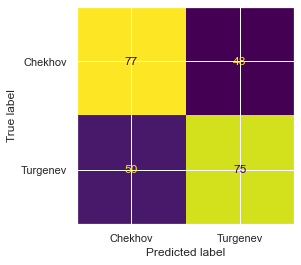

In [31]:
from sklearn.metrics import plot_confusion_matrix

best_SVC_model = cv_result_SVC['estimator'][np.argmax(cv_result_SVC['test_accuracy'])]

plot_confusion_matrix(best_SVC_model, test_texts, test_y, display_labels=two_author, colorbar=False)
plt.show()

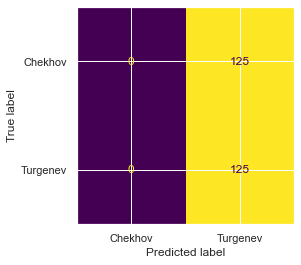

In [32]:
best_logit_model = cv_result_Logit['estimator'][np.argmax(cv_result_Logit['test_accuracy'])]
plot_confusion_matrix(best_logit_model, test_texts.toarray(), test_y, display_labels=two_author, colorbar=False)
plt.show()

## Summary
From the calculated metrics it is immediately clear that our model is much slower, and also clearly undertrained due to the lack of data, because of this all its metrics are extremely low. SVC, on the other hand, learns well from the available data and shows not bad results of more than 60% of correct answers.  

In [33]:
from sklearn.model_selection import GridSearchCV

parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma' : ['scale', 'auto']}

model_SVC = SVC(probability=True)
clf_svc = GridSearchCV(model_SVC, parameters, scoring = 'roc_auc', cv=3, n_jobs=8)
clf_svc.fit(train_texts, train_y)
print('Best parameters: ', clf_svc.best_params_)

Best parameters:  {'C': 1, 'gamma': 'scale'}


In [34]:
df = pd.DataFrame(clf_svc.cv_results_['params'])
df.insert(2, "roc_auc", clf_svc.cv_results_['mean_test_score'], True)
df

,C,gamma,roc_auc
0,0.001,scale,0.645323
1,0.001,auto,0.641365
2,0.010,scale,0.644800
3,0.010,auto,0.641365
4,0.100,scale,0.644939
5,0.100,auto,0.641365
6,1.000,scale,0.646133
7,1.000,auto,0.641365
8,10.000,scale,0.645120
9,10.000,auto,0.641365


In [35]:
parameters = {'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'beta' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

model_logit = Logit()
clf_logit = GridSearchCV(model_logit, parameters, scoring=make_scorer(roc_auc_score), cv=3, n_jobs=8)
clf_logit.fit(train_texts.toarray(), train_y)
print('Best parameters: ', clf_logit.best_params_)

100%|██████████| 1000/1000 [00:21<00:00, 46.80it/s]

Best parameters:  {'beta': 0.1, 'gamma': 10}


In [36]:
df = pd.DataFrame(clf_logit.cv_results_['params'])
df.insert(2, "roc_auc", clf_logit.cv_results_['mean_test_score'], True)
df

,beta,gamma,roc_auc
0,0.001,0.001,0.464000
1,0.001,0.010,0.464000
2,0.001,0.100,0.480000
3,0.001,1.000,0.500000
4,0.001,10.000,0.514667
5,0.001,100.000,0.497333
6,0.001,1000.000,0.480000
7,0.010,0.001,0.465333
8,0.010,0.010,0.468000
9,0.010,0.100,0.481333


## Summary

Using GridSearch we can conclude that the best parameters for SVC are 'C': 1, 'gamma': 'scale' and for our model 'beta': 0.1, 'gamma': 10. In this case we can see a significant dependence of the models on the parameters. Our model, as said before, obviously lacks data for training, but it still improves results if we carefully select the parametres.

#### 9. [1 point] Analysing ROC_AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate 

In [37]:
model_1 = clf_logit.best_estimator_
model_2 = clf_svc.best_estimator_

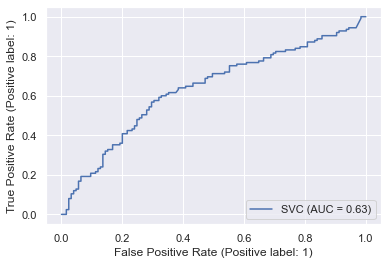

In [38]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve

plot_roc_curve(model_2, test_texts, test_y)

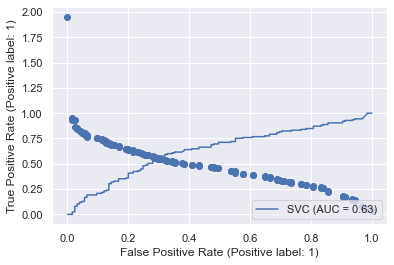

In [39]:

plot_roc_curve(model_2, test_texts, test_y)
fpr, tpr, thresholds = roc_curve(test_y, model_2.predict_proba(test_texts)[:,1])
plt.scatter(fpr, thresholds)
plt.show()

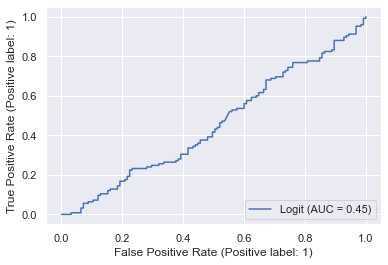

In [40]:
plot_roc_curve(model_1, test_texts.toarray(), test_y)

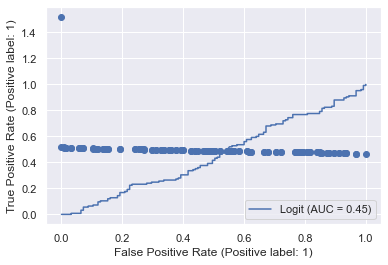

In [41]:
plot_roc_curve(model_1, test_texts.toarray(), test_y)
fpr, tpr, thresholds = roc_curve(test_y, model_1.predict_proba(test_texts.toarray()).T[0])
plt.scatter(fpr, thresholds)
plt.show()

In [42]:
fpr, tpr, thresholds = roc_curve(test_y, model_1.predict_proba(test_texts.toarray()).T[0])
logit_threshold = (fpr > 0.3).argmax()

thresholds[logit_threshold]

0.49700760863271204

### Multiclass logit

#### 10. [1 point] Take the One-VS-Rest classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRestClassifier</a>

* use the whole dataset with 6 authors
* divide the data into train and test samples with 3/4 split rate
* train the model using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)
* using GridSearchCV - find the best parameters for the models (by averaged ROC_AUC score)
* make conclusions about the model

In [43]:
train_texts, test_texts, train_y, test_y = train_test_split(data_x, data_y, test_size=0.995,
                                                            random_state=42, stratify = data_y)
vectorizer_tf = TfidfVectorizer()
vectorizer_tf.fit(train_texts)
train_X_tf = vectorizer_tf.transform(train_texts)
test_X_tf  = vectorizer_tf.transform(test_texts)

In [44]:
from sklearn.multiclass import OneVsRestClassifier

multi_clf = OneVsRestClassifier(Logit(0.1, 10)).fit(train_X_tf.toarray(), train_y)

100%|██████████| 1000/1000 [00:10<00:00, 98.36it/s]


In [45]:
multi_clf.predict(train_X_tf.toarray())

array(['Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dostoevsky',
       'Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dostoevsky',
       'Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dostoevsky',
       'Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dostoevsky',
       'Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dostoevsky',
       'Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dostoevsky',
       'Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dostoevsky',
       'Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dostoevsky',
       'Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dostoevsky',
       'Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dostoevsky',
       'Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dostoevsky',
       'Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dostoevsky',
       'Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dostoevsky',
       'Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dostoevsky',
       'Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dostoevsky',
       'Dostoevsky', 'Dostoevsky', 'Dostoevsky', 'Dosto

In [46]:
from sklearn.multiclass import OneVsRestClassifier

multi_clf = OneVsRestClassifier(Logit(0.1, 10))
cv_result_multi_clf = cross_validate(multi_clf, train_X_tf.toarray(), train_y,
                                     return_estimator=True, cv=3)

pd.DataFrame(cv_result_multi_clf).T

100%|██████████| 1000/1000 [00:09<00:00, 107.25it/s]


,0,1,2
fit_time,36.531876,36.110437,55.866645
score_time,0.003022,0.00309,0.002932
estimator,"OneVsRestClassifier(estimator=Logit(beta=0.1, ...","OneVsRestClassifier(estimator=Logit(beta=0.1, ...","OneVsRestClassifier(estimator=Logit(beta=0.1, ..."
test_score,0.34375,0.348958,0.350785


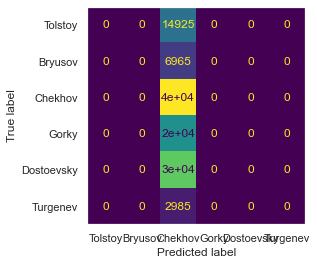

In [52]:
best_multi_clf_model = cv_result_multi_clf['estimator'][np.argmax(cv_result_multi_clf['test_score'])]
plot_confusion_matrix(best_multi_clf_model, test_X_tf.toarray(), test_y, display_labels=authors, colorbar=False)
plt.grid(False)
plt.show()

## Summary 

Multiclass Logit show score 0.34. Model choose author with bigest amount of sentence and put every where this author. It happenes becouse our sample is't balanced and there is no enough data for fitting.